## What Percentage of all E-Scooter Rides End at Street Corners VS Mid-Block?

## Step 1: Acquire Data

- Scooter Ride End Points
    * Available from MDS, an API written by the City of Los Angeles and populated by E-Scooter Companies
    * Cole pulls the data from MDS and then creates a feature class that lives on a City server
- Intersections
    * The City does not have an intersection dataset 
    * The City does have a road centerline dataset which can be used to <i>approximate</i> intersections


<img src= "https://github.com/strmwtr/scooter_endpoints/blob/master/intersections/rcl.png?raw=true">
<img src="https://github.com/strmwtr/scooter_endpoints/blob/master/intersections/endpoints.png?raw=true">

## Step 2: Prepare

- Scooter Ride End Points are readily available thanks to Cole. No need for further prep at this time.

- Intersections need to be appoximated based on road centerline data
    * First, determine how accurate this data needs to be based on key points 
        * Reported inaccuracy of the scooter point data 
        * This is one of many pieces to this overall data analysis project
        * Data will be used for general information purposes only

    * Considering the points above, a rough approximating with minimal cleaning will suffice, provided a clear explanation as to how the data was created is provided.

    * Measure several road widths from curb to curb and determine an average road width. 
        * 150 feet from curb to curb seems to be a good approximation.
            
    * Take that same estimate and apply it to a radius for intersections
            
    * Buffer road centerlines by 75 feet on both sides
    
    * Dissolve buffered centerlines 
        
    * Intersect road centerlines with itself to create intersection points
        * Realize that this creates unintended side effects, like an intersection being created in an overpass situation
            
    * Buffer the intersected points by 75 feer
    
    * Dissolve buffered intersection points to create a road intersection feature
        
    * Erase intersection feature from buffered road center line layer to create a mid-block feature

In [ ]:
import arcpy

#Databases
gdb = r'\path\to\Scooter.gdb'
sde = r'Database Connections\Connection to GISPRDDB.sde'

#Source data
rcl = f'{sde}\cvgis.CITY.Transportation_Road\cvGIS.CITY.road_centerline'

#Derived Data
rcl_buff = f'{gdb}/road_centerline_buffer'
rcl_dis = f'{gdb}/road_centerline_dis'
rcl_int = f'{gdb}/road_centerline_int'
rcl_int_buff = f'{gdb}/road_centerline_int_buff'
block_endpoints = f'{gdb}/block_endpoints'
block_midpoints = f'{gdb}/block_midpoints'


arcpy.Buffer_analysis(
  in_features= rcl,
  out_feature_class= rcl_buff
  buffer_distance_or_field="75 Feet", 
  line_side="FULL", 
  line_end_type="ROUND", 
  dissolve_option="NONE", 
  dissolve_field="", 
  method="PLANAR")

arcpy.Dissolve_management(
  in_features= rcl_buff, 
  out_feature_class= rcl_dis, 
  dissolve_field="", 
  statistics_fields="", 
  multi_part="MULTI_PART", 
  unsplit_lines="DISSOLVE_LINES")

arcpy.Intersect_analysis(
  in_features= rcl, 
  out_feature_class= rcl_int, 
  join_attributes="ALL", 
  cluster_tolerance="-1 Unknown", 
  output_type="POINT")

arcpy.Buffer_analysis(
  in_features= rcl_int,
  out_feature_class= rcl_int_buff
  buffer_distance_or_field="75 Feet", 
  line_side="FULL", 
  line_end_type="ROUND", 
  dissolve_option="NONE", 
  dissolve_field="", 
  method="PLANAR")

arcpy.Dissolve_management(
  in_features= rcl_int_buff, 
  out_feature_class= rcl_int_buff_dis, 
  dissolve_field="", 
  statistics_fields="", 
  multi_part="MULTI_PART", 
  unsplit_lines="DISSOLVE_LINES")

arcpy.Erase_analysis(
  in_features= rcl_dis, 
  erase_features= block_endpoints, 
  out_feature_class= block_midpoints, 
  cluster_tolerance="")

<img src="https://github.com/strmwtr/scooter_endpoints/blob/master/intersections/dis_rcl.png?raw=true">
<img src="https://github.com/strmwtr/scooter_endpoints/blob/master/intersections/end_block.png?raw=true">
<img src="https://github.com/strmwtr/scooter_endpoints/blob/master/intersections/mid_block.png?raw=true">
<img src="https://github.com/strmwtr/scooter_endpoints/blob/master/intersections/mid_and_end_of_block.png?raw=true">

## Step 3: Analyze

- Select by location all points within intersection feature, divide by total number of points, and multiply by 100 to get percent of rides the end in intersections
        
- Select by location all points within mid-block feature, divide by total number of points, and multiply by 100 to get percent of rides the end in intersections
        
- Subtract mid-point and intersection counts from total number of ride end points, divide by total number of points, and multiply by 100 to get the percentage of rides that do not end in an intersection or mid-block

<img src="https://github.com/strmwtr/scooter_endpoints/blob/master/intersections/rides_end_of_block.png?raw=true">
<img src="https://github.com/strmwtr/scooter_endpoints/blob/master/intersections/rides_mid_of_block.png?raw=true">

## Step 4: Report
    
- Create an easily readable chart with the findings

In [2]:
total_rides = 96000

def percent_total_rides(ride_count):
    percent_rides = ride_count / total_rides * 100
    percent_rides = round(percent_rides, 2)
    return percent_rides

end_count = 16811
mid_count = 30921
neither_count = total_rides - end_count - mid_count

percent_ride_tbl = [
    ['All Rides', total_rides, percent_total_rides(total_rides)],
    ['End Block', end_count, percent_total_rides(end_count)],
    ['Mid Block', mid_count, percent_total_rides(mid_count)],
    ['Neither', neither_count, percent_total_rides(neither_count)],
    ]

print(['End Locations', 'Number of Rides', 'Percent'])
for x in percent_ride_tbl:
    print(x)


['End Locations', 'Number of Rides', 'Percent']
['All Rides', 96000, 100.0]
['End Block', 16811, 17.51]
['Mid Block', 30921, 32.21]
['Neither', 48268, 50.28]


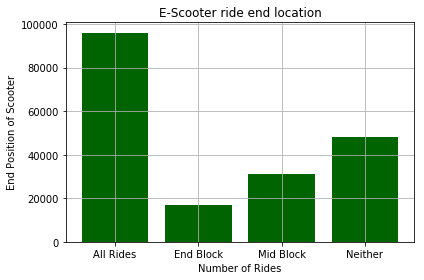

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

plot_x = [x[0] for x in percent_ride_tbl]
plot_y = [y[1] for y in percent_ride_tbl]
plt.bar(plot_x, plot_y, color = '#006400')
plt.title('E-Scooter ride end location')
plt.xlabel('Number of Rides')
plt.ylabel('End Position of Scooter')
plt.grid(True)
plt.tight_layout()

plt.show()

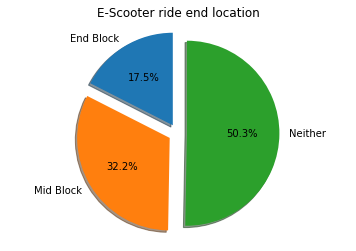

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt

pie_labels = [x[0] for x in percent_ride_tbl[1:]]
sizes = [y[2] for y in percent_ride_tbl[1:]]
explode = (0.1,0.1,0.1)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=pie_labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('E-Scooter ride end location')
plt.show()

## Step 5: Act
    
- Data analysis has been turned over to Amanda and Jason. They will use it to draw conclusions and make reccomendations to council on how to proceed with our E-Scooter program

- On 6/17/19 this information helped Council decided to continue the E-Scooter program and to hire a part time employee for the program